## Primeros modelos



En esta notebbok se utiliza los datos del dataset de HR de la forma en que se bajó el dataset, sin una limpieza previa.
Se probaron 2 modelos LogisticRegression y GradientBoostingClassifier, también se utilizó validación cruzada y ajuste de los mejores hyperparametros con GridSearchCV.

In [ ]:
# Librerias

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import make_column_selector as selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import HistGradientBoostingClassifier

from scipy.stats import loguniform

from pprint import pprint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Carga del dataset

data_raw = pd.read_csv('/content/drive/MyDrive/No Country - Data-BI Simulation/Dataset/hranalytics_seleccionado/WA_Fn-UseC_-HR-Employee-Attrition.csv')
data_raw.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [ ]:
# Carga de DFs con datos de entrenamiento

data, target = data_raw.drop(columns = 'Attrition'), data_raw['Attrition']

In [ ]:
data.dtypes

Age                          int64
BusinessTravel              object
DailyRate                    int64
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
EmployeeNumber               int64
EnvironmentSatisfaction      int64
Gender                      object
HourlyRate                   int64
JobInvolvement               int64
JobLevel                     int64
JobRole                     object
JobSatisfaction              int64
MaritalStatus               object
MonthlyIncome                int64
MonthlyRate                  int64
NumCompaniesWorked           int64
Over18                      object
OverTime                    object
PercentSalaryHike            int64
PerformanceRating            int64
RelationshipSatisfaction     int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears            int64
TrainingTimesLastYea

In [ ]:
#Separando columnas por categoria

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data)
categorical_columns = categorical_columns_selector(data)

In [ ]:
# Se definde Preprocesor para categorical y numerical

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [ ]:
# Se crea el transformer

preprocessor = ColumnTransformer(
    [
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
        ("standard_scaler", numerical_preprocessor, numerical_columns),
    ]
)

NameError: name 'ColumnTransformer' is not defined

In [ ]:
# Se define el modelo, en este caso un Regresión Logística

model = make_pipeline(preprocessor, LogisticRegression(max_iter=500))
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'Over18', 'OverTime']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'Education', 'EmployeeCount',
                                                   'EmployeeNumber'...
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'PerformanceRating',
                                                   'RelationshipSatisfaction',
                                                   'StandardHours',
                                                   'StockOptionLevel',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'WorkLifeBalance',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [ ]:
# Split de datos en entrenamiento y test

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=42
)

In [ ]:
# Entrenamiento

_ = model.fit(data_train, target_train)

In [ ]:
# Las 5 primeras predicciones

model.predict(data_test)[:5]

array(['No', 'No', 'No', 'No', 'No'], dtype=object)

In [ ]:
# Score de este 1° modelo

model.score(data_test, target_test)

0.8967391304347826

## Evaluación con Cross-validation

In [ ]:
# Validación Cruzada

cv_results = cross_validate(model, data, target, cv=5)
cv_results

{'fit_time': array([0.05257344, 0.05825067, 0.05517912, 0.08816957, 0.06261063]),
 'score_time': array([0.01246738, 0.01508164, 0.0121479 , 0.01249266, 0.01297092]),
 'test_score': array([0.9047619 , 0.87755102, 0.86394558, 0.87414966, 0.89455782])}

In [ ]:
# Media de la puntuación con margen superior e inferior

scores = cv_results["test_score"]
print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

The mean cross-validation accuracy is: 0.883 ± 0.015


## Probando con Gradient Boosting Trees en este caso HistGradientBoostingClassifier HGBC

In [ ]:
# Con GBT no es necesario escalar los atributos numericos.

# En este caso quiero ver el resultado utilizando OrdinalEncoder en lugar de OneHotEncoder

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)

preprocessor = ColumnTransformer(
    [("categorical", categorical_preprocessor, categorical_columns)],
    remainder="passthrough",
)

model = make_pipeline(preprocessor, HistGradientBoostingClassifier())
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'Over18', 'OverTime'])])),
                ('histgradientboostingclassifier',
                 HistGradientBoostingClassifier())])

In [ ]:
%%time
_ = model.fit(data_train, target_train)

CPU times: user 1 s, sys: 5.03 ms, total: 1.01 s
Wall time: 547 ms


In [ ]:
model.score(data_test, target_test)

0.875

In [ ]:
# Validación Cruzada

cv_results = cross_validate(model, data, target, cv=5)
cv_results

{'fit_time': array([0.61269069, 0.53385019, 0.56272912, 0.48620987, 0.48016047]),
 'score_time': array([0.01219416, 0.01307344, 0.0118556 , 0.01063251, 0.01285124]),
 'test_score': array([0.84693878, 0.8537415 , 0.86394558, 0.86734694, 0.8537415 ])}

In [ ]:
# Media de la puntuación con margen superior e inferior

scores = cv_results["test_score"]
print(
    "The mean cross-validation accuracy is: "
    f"{scores.mean():.3f} ± {scores.std():.3f}"
)

The mean cross-validation accuracy is: 0.857 ± 0.007


## Tuning del modelo utilizando grid-search

In [ ]:
# Se crea un nuevo modelo

model = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4),
        ),
    ]
)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'Over18', 'OverTime'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

In [ ]:
# Se define el estimador GridSearchCV

%%time
param_grid = {
    "classifier__learning_rate": (0.01, 0.1, 1, 10),
    "classifier__max_leaf_nodes": (3, 10, 30),
}
model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=2)
model_grid_search.fit(data_train, target_train)

CPU times: user 582 ms, sys: 71.8 ms, total: 654 ms
Wall time: 6.88 s


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'Over18',
                                                                          'OverTime'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                                       random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': (0.01, 0.1, 1, 10),
                         'classifier__max_leaf_nodes': (3, 10, 30)})

In [ ]:
# Utilizando el test_set vemos en accuracy del modelo

accuracy = model_grid_search.score(data_test, target_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: {accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.87


In [ ]:
# Primeras 5 predicciones

model_grid_search.predict(data_test.iloc[0:5])

array(['No', 'No', 'No', 'No', 'No'], dtype=object)

In [ ]:
# Los mejores parametros utilizados en la predicción

print(f"The best set of parameters is: {model_grid_search.best_params_}")

The best set of parameters is: {'classifier__learning_rate': 1, 'classifier__max_leaf_nodes': 10}


In [ ]:
# Se crea un DF con los datos obtenidos por GridSearch

cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
7,0.212080,0.008711,0.024771,0.000736,1,10,"{'classifier__learning_rate': 1, 'classifier__...",0.874773,0.838475,0.856624,0.018149,1
3,0.194763,0.021856,0.029279,0.012128,0.1,3,"{'classifier__learning_rate': 0.1, 'classifier...",0.858439,0.852995,0.855717,0.002722,2
8,0.248760,0.006758,0.019841,0.001918,1,30,"{'classifier__learning_rate': 1, 'classifier__...",0.858439,0.849365,0.853902,0.004537,3
5,0.450927,0.008314,0.025482,0.001783,0.1,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.852995,0.851180,0.852087,0.000907,4
4,0.469916,0.007354,0.029036,0.007391,0.1,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.856624,0.838475,0.847550,0.009074,5


In [ ]:
# Se obtiene el nombre de los parametros

column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [ ]:
# Se define una función para eliminar el texto "param_classifier"

def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

# Vemos como queda el DF con los resultados

cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
7,1,10,0.856624,0.018149,1
3,0.1,3,0.855717,0.002722,2
8,1,30,0.853902,0.004537,3
5,0.1,30,0.852087,0.000907,4
4,0.1,10,0.847550,0.009074,5
2,0.01,30,0.843013,0.008167,6
1,0.01,10,0.839383,0.006352,7
0,0.01,3,0.832123,0.000907,8
6,1,3,0.831216,0.010889,9
11,10,30,0.575318,0.054446,10


In [ ]:
# Heat map de cv results donde se cruza el learning_rate con la cantidad de nodos del arbol

pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["learning_rate"],
    columns=["max_leaf_nodes"],
)

pivoted_cv_results

max_leaf_nodes,3,10,30
learning_rate,,,
0.01,0.832123,0.839383,0.843013
0.10,0.855717,0.847550,0.852087
1.00,0.831216,0.856624,0.853902
10.00,0.244102,0.516334,0.575318


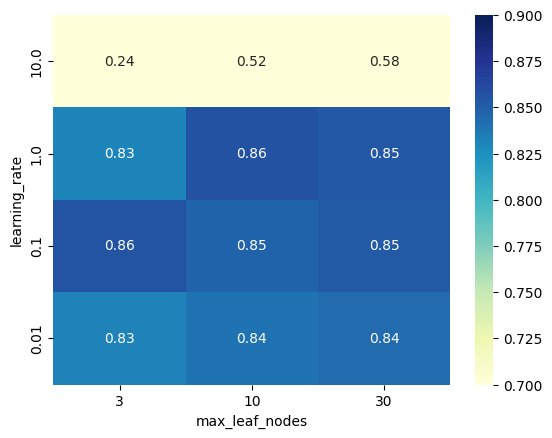

In [ ]:
# Heatmap presentación

ax = sns.heatmap(
    pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7, vmax=0.9
)
ax.invert_yaxis()

## Tuning del modelo utilizando randomized_search

In [ ]:
# Se adapta loguniform para generar valores random de enteros

class loguniform_int:
    """Integer valued version of the log-uniform distribution"""

    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

In [ ]:
# Se ejecura 10 iteracciones de 5 validaciones cruzadas para valores randomicos de parametrización

param_distributions = {
    "classifier__l2_regularization": loguniform(1e-6, 1e3),
    "classifier__learning_rate": loguniform(0.001, 10),
    "classifier__max_leaf_nodes": loguniform_int(2, 256),
    "classifier__min_samples_leaf": loguniform_int(1, 100),
    "classifier__max_bins": loguniform_int(2, 255),
}

model_random_search = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    verbose=1,
)
model_random_search.fit(data_train, target_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('categorical',
                                                                               OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                              unknown_value=-1),
                                                                               ['BusinessTravel',
                                                                                'Department',
                                                                                'EducationField',
                                                                                'Gender',
                                                                                'JobRole',
                                                                                'MaritalStatus',
                                                                                'Over18',
                                                                                'OverTime'])])),
                                             ('classifier',
                                              HistGradientBoostingCla...
                   param_distributions={'classifier__l2_regularization': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c448d5acee0>,
                                        'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7c448c1038e0>,
                                        'classifier__max_bins': <__main__.loguniform_int object at 0x7c448c102470>,
                                        'classifier__max_leaf_nodes': <__main__.loguniform_int object at 0x7c448c103d00>,
                                        'classifier__min_samples_leaf': <__main__.loguniform_int object at 0x7c448c103820>},
                   verbose=1)

In [ ]:
# Resultado del accuracy

accuracy = model_random_search.score(data_test, target_test)

print(f"The test accuracy score of the best model is {accuracy:.2f}")

The test accuracy score of the best model is 0.89


In [ ]:
# Mejores parametros

print("The best parameters are:")
pprint(model_random_search.best_params_)

The best parameters are:
{'classifier__l2_regularization': 0.00017833195317351044,
 'classifier__learning_rate': 0.07632863002832416,
 'classifier__max_bins': 6,
 'classifier__max_leaf_nodes': 239,
 'classifier__min_samples_leaf': 88}


In [ ]:
# get the parameter names

column_results = [f"param_{name}" for name in param_distributions.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]

cv_results = pd.DataFrame(model_random_search.cv_results_)
cv_results = cv_results[column_results].sort_values(
    "mean_test_score", ascending=False
)


def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name


cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
7,0.000178,0.076329,239,88,6,0.864759,0.018666,1
3,0.670692,0.062285,35,26,204,0.853871,0.019339,2
2,0.043274,0.015355,54,4,116,0.847524,0.017804,3
9,0.000312,0.094881,21,3,79,0.845738,0.018760,4
1,0.03989,0.453851,4,4,3,0.833920,0.014130,5
0,812.77666,0.25267,72,13,5,0.828494,0.001698,6
4,0.000376,0.00185,55,45,228,0.828494,0.001698,6
5,0.009344,0.002791,121,62,23,0.828494,0.001698,6
6,0.000062,3.115619,7,5,130,0.677252,0.206490,9
8,0.000041,6.511265,41,1,2,0.559017,0.145940,10


In [ ]:
# Este tuning está limitado por el número de diferentes combinaciones de los parametros
# Se prueba realizando 500 iteracciones y guardando el resultado en un .csv
# Este paso ya fue ejecutado y el archivo .csv correspondiente está en la carpeta

# model_random_search = RandomizedSearchCV(
    # model, param_distributions=param_distributions, n_iter=500,
    # n_jobs=2, cv=5)
# model_random_search.fit(data_train, target_train)
# cv_results =  pd.DataFrame(model_random_search.cv_results_)
# cv_results.to_csv("../content/drive/MyDrive/No Country - Data-BI Simulation/Colab - ML Model/randomized_search_results.csv")

In [ ]:
# DF con los resultados, no está ordenado

cv_results = pd.read_csv(
    "../content/drive/MyDrive/No Country - Data-BI Simulation/Colab - ML Model/randomized_search_results.csv", index_col=0
)

(
    cv_results[column_results]
    .rename(shorten_param, axis=1)
    .sort_values("mean_test_score", ascending=False)
)

,l2_regularization,learning_rate,max_leaf_nodes,min_samples_leaf,max_bins,mean_test_score,std_test_score,rank_test_score
83,323.313483,2.370444,4,62,177,0.879317,0.009676,1
402,880.433981,4.963327,3,80,17,0.878396,0.010953,2
410,263.578571,5.939196,2,25,6,0.876565,0.011129,3
40,0.009068,0.332767,2,11,218,0.875656,0.012274,4
178,0.000001,0.619316,2,4,44,0.874755,0.008668,5
...,...,...,...,...,...,...,...,...
216,0.000296,5.428107,2,3,177,0.394439,0.222109,496
419,0.008779,7.354256,19,7,2,0.335812,0.089482,497
435,0.000016,4.015034,16,4,20,0.333077,0.165031,498
389,0.000029,9.589560,17,4,32,0.299556,0.122872,499


## Finalmente se combina la etapa de tuning de hyperparametros con el entrenamiento del modelo

In [ ]:
# Se pasa el modelo al grid-search

param_grid = {
    "classifier__learning_rate": (0.05, 0.5),
    "classifier__max_leaf_nodes": (10, 30),
}
model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=2)
model_grid_search.fit(data, target)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('categorical',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'Over18',
                                                                          'OverTime'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                                       random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': (0.05, 0.5),
                         'classifier__max_leaf_nodes': (10, 30)})

In [ ]:
# La mejor combinación se pasa a cross validation

cv_results = pd.DataFrame(model_grid_search.cv_results_)
cv_results[
    [
        "param_classifier__learning_rate",
        "param_classifier__max_leaf_nodes",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
]

,param_classifier__learning_rate,param_classifier__max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
0,0.05,10,0.858503,0.002721,1
1,0.05,30,0.856463,0.003401,2
2,0.5,10,0.853741,0.004762,3
3,0.5,30,0.851020,0.000680,4


In [ ]:
model_grid_search.best_params_

{'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 10}

In [ ]:
# Entrenamiento del modelo con los mejores hyperparmetros

data_train, data_test, target_train, target_test = train_test_split(
    data, target, test_size=0.2, random_state=42
)

model_grid_search.fit(data_train, target_train)
accuracy = model_grid_search.score(data_test, target_test)
print(f"Accuracy on test set: {accuracy:.3f}")

Accuracy on test set: 0.874


In [ ]:
# Se generaliza la performance del modelo

cv_results = cross_validate(
    model_grid_search, data, target, cv=5, n_jobs=2, return_estimator=True
)

In [ ]:
cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results["test_score"]
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} ± {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
0.866 ± 0.015


In [ ]:
# Visualización de los mejores hyperparametros por cada fold de la validación cruzada

for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'classifier__learning_rate': 0.5, 'classifier__max_leaf_nodes': 30}
Best hyperparameters for fold #2:
{'classifier__learning_rate': 0.5, 'classifier__max_leaf_nodes': 30}
Best hyperparameters for fold #3:
{'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 10}
Best hyperparameters for fold #4:
{'classifier__learning_rate': 0.5, 'classifier__max_leaf_nodes': 30}
Best hyperparameters for fold #5:
{'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 10}
